In [1]:
!pip install vit-pytorch>=0.35.8
!pip install coca-pytorch

In [2]:
import pandas as pd
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image

## Data setup

### Load data

In [3]:
DATASET_PATH = "../input/flicker-8k-image-dataset-captionstxt/"
CAPTION_PATH = DATASET_PATH + "captions.txt"
IMGS_PATH = DATASET_PATH + "Images/"

captions_df = pd.read_csv(Path(CAPTION_PATH), sep=',')
captions_df.sample(5)

,image,caption
14397,276356412_dfa01c3c9e.jpg,A light brown dog is poking his head into brush .
36133,421730441_6b2267fd31.jpg,Man wearing black shirt standing in front of a...
19257,3052196390_c59dd24ca8.jpg,Children play in a water spray .
16184,2881441125_b580e3dd4b.jpg,Two small children are gathering water from a ...
8683,2405599120_ec5f32af6f.jpg,A toddler sits with diapers spread around the ...


In [4]:
def get_captions(object_id):
    image_name = captions_df.image.values[object_id]
    return captions_df[captions_df.image == image_name].caption

def get_image(object_id):
    image_name = captions_df.image.values[object_id]
    image_pass = Path(IMGS_PATH + image_name)
    image = Image.open(image_pass)
    img_tensor = transforms.PILToTensor()(image)
    return img_tensor

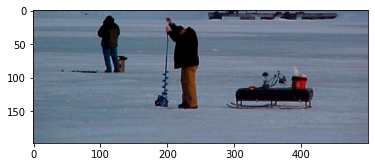

                A man drilling a hole in the ice .
A man is drilling through the frozen ice of a p...
 A person in the snow drilling a hole in the ice .
              A person standing on a frozen lake .
                         Two men are ice fishing . 



In [5]:
def show_instase(object_id):
    image = get_image(object_id)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

    captions = get_captions(object_id).to_string(index=False)
    print(captions, '\n')

show_instase(95)

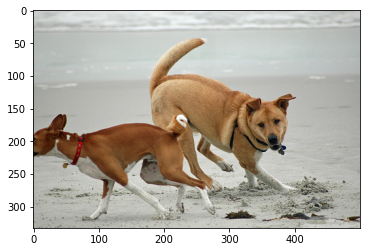

Two different breeds of brown and white dogs pl...
 Two dogs are making a turn on a soft sand beach .
       Two dogs playing in the sand at the beach .
            Two dogs playing together on a beach .
     Two large tan dogs play along a sandy beach . 



In [6]:
show_instase(100)

### Embed texts

In [7]:
import sentencepiece as spm

VOCAB_SIZE = 10000
N = 70

spm.SentencePieceTrainer.train(
    input=CAPTION_PATH,
    model_prefix='spm',
    vocab_size=VOCAB_SIZE,
    pad_id=3,
)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../input/flicker-8k-image-dataset-captionstxt/captions.txt
  input_format: 
  model_prefix: spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_no

In [8]:
PAD_VALUE = 3

sp = spm.SentencePieceProcessor(
    model_file='./spm.model', add_bos=True, add_eos=True)

def encode(x):
    x = sp.encode(x, out_type=int)
    padded = x + [PAD_VALUE] * max(0, (N - len(x))),
    return padded[0]

captions_df['inds'] = captions_df.caption.apply(encode)
captions_df['inds'].head(3)

0    [1, 22, 10, 77, 11, 4, 137, 357, 23, 267, 83, ...
1    [1, 22, 10, 40, 433, 20, 96, 4, 359, 113, 253,...
2    [1, 22, 10, 76, 63, 40, 267, 96, 4, 359, 113, ...
Name: inds, dtype: object

### Create datasets and loaders

In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(captions_df, test_size=0.1)

In [10]:
from torch.utils.data import Dataset, DataLoader

class FlickrDataset(Dataset):
  def __init__(self, df, transform):
    self.inds=df.inds
    self.images=df.image
    self.transform = transform
 
  def __len__(self):
    return self.inds.shape[0]

  def __getitem__(self,idx):
    text = self.inds.iloc[idx]
    img = Image.open(IMGS_PATH + self.images.iloc[idx])
    return self.transform(img), torch.tensor(text).long()

train_t = transforms.Compose([
        transforms.PILToTensor(),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
])

val_t = transforms.Compose([
        transforms.PILToTensor(),
        transforms.CenterCrop(256),
])

train_dataset = FlickrDataset(train_df, train_t)
val_dataset = FlickrDataset(val_df, val_t)
print(train_dataset.__len__())
print(val_dataset.__len__())

36409
4046


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

for batch in train_dataloader:
    text, images = batch
    print(text.shape)
    print(images.shape)
    break

torch.Size([64, 3, 256, 256])
torch.Size([64, 70])


## Model

### CoCa

<img src="https://drive.google.com/uc?export=view&id=1_J4rprEE0P8680vpmaDbcDtktJX1C-ny" alt="drawing" width="700"/>


In [12]:
#image encoder

from vit_pytorch import ViT
from vit_pytorch.extractor import Extractor

vit = ViT(
    image_size = 256,
    patch_size = 64,
    num_classes = 1000,
    dim = 512,
    depth = 6,
    heads = 8,
    mlp_dim = 2048
)

vit = Extractor(vit, return_embeddings_only = True, detach = False)

In [13]:
from coca_pytorch.coca_pytorch import CoCa

coca = CoCa(
    dim = 256,                     # model dimension
    img_encoder = vit,
    image_dim = 512,               # image embedding dimension, if not the same as model dimensions
    num_tokens = 10000,            # number of text tokens
    unimodal_depth = 6,
    multimodal_depth = 6,
    dim_head = 64,                 # dimension per attention head
    heads = 6,                     # number of attention heads
    caption_loss_weight = 2.,
    contrastive_loss_weight = 1.,
).cuda()

<img src="https://drive.google.com/uc?export=view&id=1ANMnaHz4Gj5PrpcrZ7UufeN9Kqj9fRkz" alt="drawing" width="700"/>




In [14]:
images, text = val_dataset.__getitem__(100)
text = torch.unsqueeze(text, 0).cuda()
images = torch.unsqueeze(images, 0).float().cuda()

text_embeds, text_tokens = coca.embed_text(text)
image_embeds, image_tokens = coca.embed_image(images)

print('Text embedding (CLS token):\t', text_embeds[0].shape)
print('Text tokens:\t\t\t', text_tokens[0].shape)
print('Image embedding:\t\t', image_embeds[0].shape)
print('Image tokens:\t\t\t', image_tokens[0].shape)

Text embedding (CLS token):	 torch.Size([256])
Text tokens:			 torch.Size([70, 256])
Image embedding:		 torch.Size([256])
Image tokens:			 torch.Size([256, 256])


<img src="https://drive.google.com/uc?export=view&id=1wZvHN4C-zwqwcw_9OusqOZB59SnaHC8v" alt="drawing" width="700"/>


In [15]:
logits = coca(text=text, images=images)

print('Output caption logits:\t', logits[0].shape)
print('N of text tokens:\t', N)
print('Vocab size:\t\t', VOCAB_SIZE)

Output caption logits:	 torch.Size([70, 10000])
N of text tokens:	 70
Vocab size:		 10000


## Training


In [17]:
import wandb
from tqdm import tqdm

In [18]:
def validate(model, val_dataloader):
    model = model.eval()
    agg_loss = []
    for images, text in tqdm(val_dataloader):
        loss = model(
            text = text.cuda(),
            images = images.float().cuda(),
            return_loss = True,
        )
        agg_loss.append(loss.item())
        torch.cuda.empty_cache()
    return sum(agg_loss) / len(val_dataloader.dataset)

def train_epoch(model, optimizer, scheduler, train_dataloader):
    model = model.train()
    torch.save(model.state_dict(), "model1")
    wandb.save('model1')
    agg_loss = []
    for images, text in tqdm(train_dataloader):
        loss = model(
            text = text.cuda(),
            images = images.float().cuda(),
            return_loss = True,
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.)
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        agg_loss.append(loss.item())
        wandb.log({"loss" : loss.item()})
        torch.cuda.empty_cache()
    return sum(agg_loss) / len(train_dataloader.dataset)

def train(model, optimizer, scheduler, train_dataloader, val_dataloader, n_epochs):
    for _ in range(n_epochs):
        train_loss = train_epoch(model, optimizer, scheduler, train_dataloader)
        val_loss = validate(model, val_dataloader)
        wandb.log({"val_loss" : val_loss})
        wandb.log({"train_loss" : train_loss})

In [19]:
optimizer = torch.optim.Adam(coca.parameters(), lr=0.5e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                           max_lr=0.5e-3,
                           epochs=30,
                           steps_per_epoch=len(train_dataloader))

In [20]:
wandb.init(project="ResSem CoCa", entity="ira_gl")
train(coca, optimizer, scheduler, train_dataloader, val_dataloader, 30)

wandb: Currently logged in as: ira_gl. Use `wandb login --relogin` to force relogin


100%|██████████| 64/64 [00:41<00:00,  1.53it/s]


In [21]:
wandb.finish()

loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,4.99938
train_loss,0.07554
val_loss,0.08033
